In [1]:
# -*- coding: utf-8 -*-
"""
Created on Sun Apr 26 17:02:49 2020

@author: nyzw
"""

#install packages if needed
#pip install #####


#import modules
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import math
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from matplotlib import rcParams
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy.stats import shapiro
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.anova import anova_lm
import warnings
warnings.filterwarnings("ignore")

In [2]:
#Import in xlsx file
FB = pd.read_excel('Facebook_Post_Prediction_Truncated.xlsx')

In [3]:
#Look at data - visually look! 
#(may also open data frame in IDE to get a "cleaner" look)

#Look at the dataset dimensions
FB.shape

(3576, 17)

### Check data type
All columns are stored as integer

In [4]:
#Check the variable types
FB.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3576 entries, 0 to 3575
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   PagePopularity       3576 non-null   int64
 1   PageCheckin          3576 non-null   int64
 2   PageTalkingAbout     3576 non-null   int64
 3   PageCategory         3576 non-null   int64
 4   CommentCount24       3576 non-null   int64
 5   PostLength           3576 non-null   int64
 6   PostShareCount       3576 non-null   int64
 7   PostPromotionStatus  3576 non-null   int64
 8   TimeLikesMeasured    3576 non-null   int64
 9   PostSunday           3576 non-null   int64
 10  PostMonday           3576 non-null   int64
 11  PostTuesday          3576 non-null   int64
 12  PostWednesday        3576 non-null   int64
 13  PostThursday         3576 non-null   int64
 14  PostFriday           3576 non-null   int64
 15  PostSaturday         3576 non-null   int64
 16  NumberLikes24        357

### Check missing value
No missing value on all columns, no need to dealing with missing data.

In [5]:
FB.isna().sum()

PagePopularity         0
PageCheckin            0
PageTalkingAbout       0
PageCategory           0
CommentCount24         0
PostLength             0
PostShareCount         0
PostPromotionStatus    0
TimeLikesMeasured      0
PostSunday             0
PostMonday             0
PostTuesday            0
PostWednesday          0
PostThursday           0
PostFriday             0
PostSaturday           0
NumberLikes24          0
dtype: int64

### Check variance and min, max
- Some columns (eg. ```PagePopularity```, ```PageCheckin```, ```PostShareCount```) have high variance and range is wide compare to the another.
- Normalization might be consider as one of preprocessing data. (In this case consider to use ***```StandardScaler```***)
- ```'PostPromotionStatus','TimeLikesMeasured','PostMonday','PostTuesday','PostWednesday'``` have no variance. Consider to drop.

In [6]:
FB.describe(include='all')

,PagePopularity,PageCheckin,PageTalkingAbout,PageCategory,CommentCount24,PostLength,PostShareCount,PostPromotionStatus,TimeLikesMeasured,PostSunday,PostMonday,PostTuesday,PostWednesday,PostThursday,PostFriday,PostSaturday,NumberLikes24
count,3.576000e+03,3.576000e+03,3.576000e+03,3576.000000,3576.000000,3576.000000,3576.000000,3576.0,3576.0,3576.000000,3576.0,3576.0,3576.0,3576.000000,3576.000000,3576.000000,3576.000000
mean,3.892342e+06,5.963859e+03,2.356619e+05,22.879754,99.506432,148.202740,193.962248,0.0,24.0,0.035794,0.0,0.0,0.0,0.366611,0.366890,0.230705,30.199385
std,8.446233e+06,4.629343e+04,4.506870e+05,19.699124,248.893619,349.325872,1001.633919,0.0,0.0,0.185803,0.0,0.0,0.0,0.481946,0.482024,0.421343,104.575135
min,8.250000e+02,0.000000e+00,0.000000e+00,1.000000,0.000000,0.000000,1.000000,0.0,24.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
25%,4.299050e+05,0.000000e+00,1.631500e+04,9.000000,3.000000,44.000000,3.000000,0.0,24.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
50%,1.514256e+06,0.000000e+00,6.951100e+04,20.000000,17.000000,97.000000,25.000000,0.0,24.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,3.000000
75%,4.351476e+06,2.700000e+01,2.598920e+05,34.000000,72.250000,161.000000,104.250000,0.0,24.0,0.000000,0.0,0.0,0.0,1.000000,1.000000,0.000000,14.000000
max,1.626244e+08,1.100558e+06,6.784263e+06,107.000000,2673.000000,10405.000000,40428.000000,0.0,24.0,1.000000,0.0,0.0,0.0,1.000000,1.000000,1.000000,2412.000000


In [7]:
to_drop_no_var = ['PostPromotionStatus','TimeLikesMeasured','PostMonday','PostTuesday','PostWednesday']
FB = FB.drop(columns = to_drop_no_var)

### Visualizing distribution of all columns
- Most of them do not have normal distribution\
```['PagePopularity', 'PageCheckin','PageTalkingAbout','CommentCount24','PostLenght','PostShareCount']```
- Also many have outliers detect by boxplot

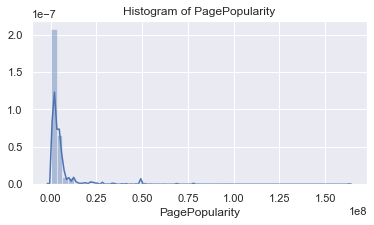

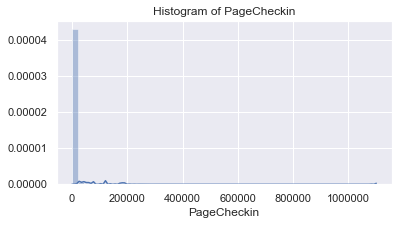

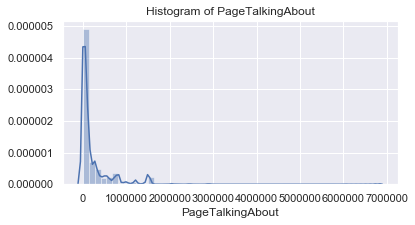

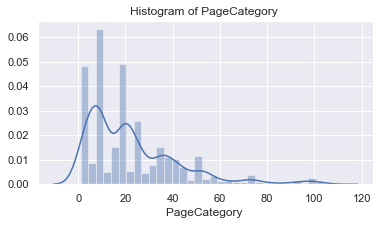

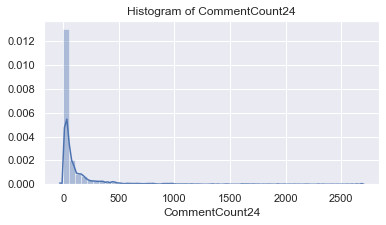

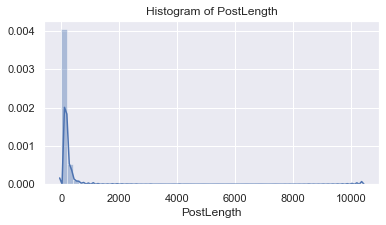

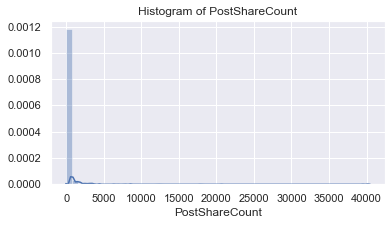

RuntimeError: Selected KDE bandwidth is 0. Cannot estiamte density.

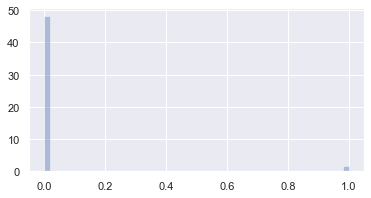

In [8]:
#Plot Histogram of all columns
import seaborn as sns
sns.set(color_codes=True)
n_bins = 50

for column_name in FB.columns:
    ax = plt.subplots(figsize=(6,3))
    ax = sns.distplot(FB[column_name])
    title='Histogram of '+ column_name
    plt.title(title,fontsize = 12)
    plt.show()

In [9]:
FB.dtypes

PagePopularity      int64
PageCheckin         int64
PageTalkingAbout    int64
PageCategory        int64
CommentCount24      int64
PostLength          int64
PostShareCount      int64
PostSunday          int64
PostThursday        int64
PostFriday          int64
PostSaturday        int64
NumberLikes24       int64
dtype: object

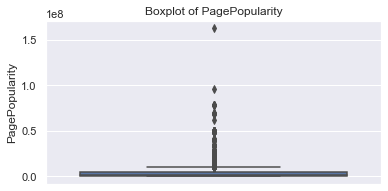

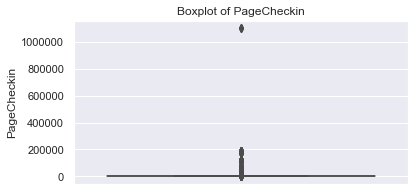

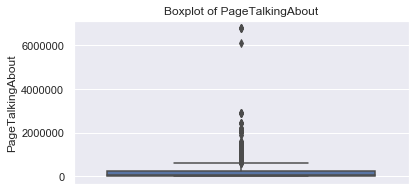

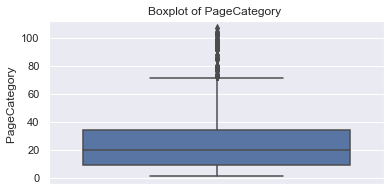

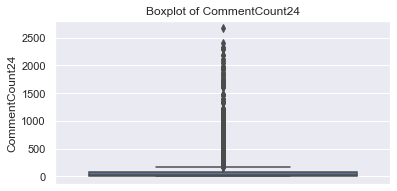

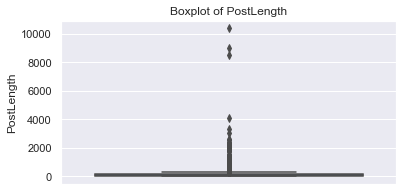

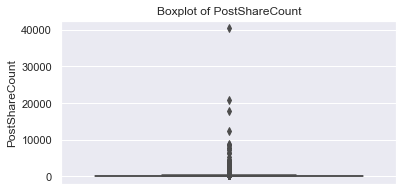

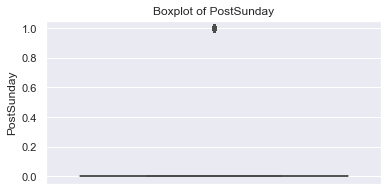

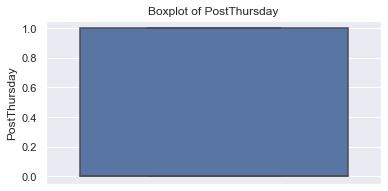

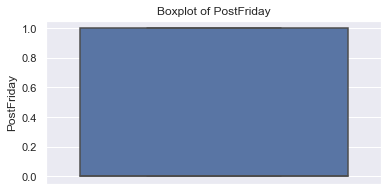

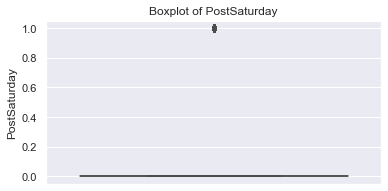

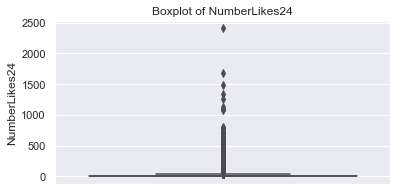

In [10]:
#Box plot of all columns

for column_name in FB.columns:
    ax = plt.subplots(figsize=(6,3))
    ax = sns.boxplot(y =FB[column_name]);
    title='Boxplot of '+ column_name
    plt.title(title,fontsize = 12)
    plt.show()

### Check the correlation between parametres and VIF of multicolinearity
- Correlation seem to be moderate (< 0.75) for pair of features
- VIF = ???

In [11]:
#Drop the columns with out variance

corr_tab = FB.corr()
corr_tab.style.background_gradient(cmap='coolwarm')

,PagePopularity,PageCheckin,PageTalkingAbout,PageCategory,CommentCount24,PostLength,PostShareCount,PostSunday,PostThursday,PostFriday,PostSaturday,NumberLikes24
PagePopularity,1.000000,0.022466,0.434448,0.007415,0.251642,-0.020956,0.203594,0.045199,0.007134,-0.029572,0.005739,0.137089
PageCheckin,0.022466,1.000000,-0.034483,-0.036444,-0.013134,0.003845,-0.000668,0.038300,-0.028205,-0.028391,0.047851,-0.013623
PageTalkingAbout,0.434448,-0.034483,1.000000,-0.043083,0.346247,-0.022371,0.383998,0.039906,-0.044091,0.000358,0.032426,0.169344
PageCategory,0.007415,-0.036444,-0.043083,1.000000,-0.059537,0.050027,-0.024466,-0.065006,0.071025,0.039497,-0.097759,-0.051946
CommentCount24,0.251642,-0.013134,0.346247,-0.059537,1.000000,-0.025914,0.285577,-0.006864,0.024280,0.004646,-0.030060,0.410151
PostLength,-0.020956,0.003845,-0.022371,0.050027,-0.025914,1.000000,-0.014609,-0.007033,-0.004793,0.008198,-0.000795,-0.013469
PostShareCount,0.203594,-0.000668,0.383998,-0.024466,0.285577,-0.014609,1.000000,0.032047,-0.004818,0.005812,-0.015269,0.200593
PostSunday,0.045199,0.038300,0.039906,-0.065006,-0.006864,-0.007033,0.032047,1.000000,-0.146585,-0.146673,-0.105512,0.074132
PostThursday,0.007134,-0.028205,-0.044091,0.071025,0.024280,-0.004793,-0.004818,-0.146585,1.000000,-0.579157,-0.416628,-0.046290
PostFriday,-0.029572,-0.028391,0.000358,0.039497,0.004646,0.008198,0.005812,-0.146673,-0.579157,1.000000,-0.416879,-0.024170


### Let clean the data !

Delete outliers by statistical method

In [12]:
#Handling outliers, delete all point above and below mean +- 3std

for column_name in FB.columns:
    std = FB[column_name].std()
    mean = FB[column_name].mean()
    threshold = std*3
    
    lower, upper = mean - threshold, mean + threshold
    FB = FB[(FB[column_name]<upper) & (FB[column_name]>lower)]

print(FB.shape)

(2952, 12)


Check variance of data set, and target high variance columns for scaling (```StandardScaler```)

In [13]:
#Check which columns to be considered as candidate for standize
print(FB.var())

to_standized = ['PagePopularity','PageCheckin','PageTalkingAbout' ,'PageCategory ','CommentCount24','PostLength','PostShareCount']
FB_to_standized= FB[to_standized]
FB_remaining = FB.drop(columns = to_standized)

PagePopularity      1.419246e+13
PageCheckin         1.988122e+08
PageTalkingAbout    5.231065e+10
PageCategory        3.011666e+02
CommentCount24      1.107708e+04
PostLength          1.841504e+04
PostShareCount      2.179752e+04
PostSunday          0.000000e+00
PostThursday        2.368147e-01
PostFriday          2.348751e-01
PostSaturday        1.816701e-01
NumberLikes24       9.080926e+02
dtype: float64


In [14]:
#Use StandardScaler to scale the dataFrame
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

FB_to_scaled = scaler.fit_transform(FB_to_standized)
FB_to_standized_DF = pd.DataFrame(FB_to_scaled, columns = to_standized)

In [15]:
#Combine dataset back and check the variance after scaling the data
FB_final = pd.concat([FB_to_standized_DF, FB_remaining.reset_index()], axis =1)
print(FB_final.var())
print(FB_final.shape)

PagePopularity      1.000339e+00
PageCheckin         1.000339e+00
PageTalkingAbout    1.000339e+00
PageCategory        1.000339e+00
CommentCount24      1.000339e+00
PostLength          1.000339e+00
PostShareCount      1.000339e+00
index               1.041950e+06
PostSunday          0.000000e+00
PostThursday        2.368147e-01
PostFriday          2.348751e-01
PostSaturday        1.816701e-01
NumberLikes24       9.080926e+02
dtype: float64
(2952, 13)


### Prepre the data  for test and train the model
Start with no cross validation for simple solutions

In [16]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

X = FB_final.drop(columns = ['NumberLikes24','index'], axis =1)
y = FB_final['NumberLikes24']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123)

### Regression Prediction
Start from simplest model to the hardest one

In [17]:
from sklearn.linear_model import LinearRegression

reg= LinearRegression()
reg.fit(X_train,y_train)

y_pred = reg.predict(X_test)

print("R^2: {}".format(reg.score(X_test, y_test)))
rmse = np.sqrt(mean_squared_error(y_test,y_pred))
print("Root Mean Squared Error: {}".format(rmse))


R^2: 0.23786951716718419
Root Mean Squared Error: 23.371595569494474


Check simple regression coefficient

In [18]:
coeff_df = pd.DataFrame(reg.coef_, X.columns, columns=['Coefficient'])  
coeff_df

,Coefficient
PagePopularity,0.403046
PageCheckin,-1.336774
PageTalkingAbout,0.785566
PageCategory,-0.589254
CommentCount24,11.963058
PostLength,0.003258
PostShareCount,5.711622
PostSunday,0.000000
PostThursday,-3.946475
PostFriday,-2.164281


Apply cross validation with 10 folds, performance improve 0.03 for r-square

In [19]:
from sklearn.model_selection import cross_val_score

reg2 = LinearRegression()
cv_score = cross_val_score(reg2,X,y, cv = 10)

print(cv_score)
print("Average 10-Fold CV r-sqaure: {}".format(np.mean(cv_score)))

[ 0.18983986  0.28030189  0.29010032  0.28753255  0.22604942  0.28901808
  0.19565446  0.3148897   0.25915793 -0.13931365]
Average 10-Fold CV r-sqaure: 0.21932305622512754


Regularization(Lasso) the model with 10 folds cross validation

In [20]:
from sklearn.linear_model import LassoCV, Lasso

lasso_cv = LassoCV(alphas=np.logspace(-6, 6, 13), cv=10, max_iter=10000)
lasso_cv.fit(X_train, y_train) 

lasso = Lasso(alpha = lasso_cv.alpha_)
lasso.fit(X_train, y_train)

y_pred = lasso.predict(X_test)

print("R^2: {}".format(lasso.score(X_test, y_test)))
rmse = np.sqrt(mean_squared_error(y_test,y_pred))
print("Root Mean Squared Error: {}".format(rmse))

R^2: 0.24041399335116842
Root Mean Squared Error: 23.332548327210503


In [21]:
# Find the highest alpha value with R-squared above 98%
la = Lasso(alpha = 0.1, random_state=0)

# Fits the model and calculates performance stats
la.fit(X_train, y_train)

n_ignored_features = sum(la.coef_ == 0)

r_squared = la.score(X_test, y_test)
rmse = np.sqrt(mean_squared_error(y_test,la.predict(X_test)))
# Print peformance stats 
print("The model can predict {0:.1%} of the variance in the test set.".format(r_squared))
print("{} out of {} features were ignored.".format(n_ignored_features, len(la.coef_)))
print("Root Mean Squared Error: {}".format(rmse))

The model can predict 24.0% of the variance in the test set.
3 out of 11 features were ignored.
Root Mean Squared Error: 23.332548327210503


Regularization(Ridge) the model with 10 folds cross validation

In [22]:
from sklearn.linear_model import RidgeCV, Ridge

ridge_cv = RidgeCV(alphas=np.logspace(-6, 6, 13), cv=10)
ridge_cv.fit(X_train, y_train)

# Instantiate ridge, fit, predict and print MSE
ridge = Ridge(alpha = ridge_cv.alpha_)
ridge.fit(X_train, y_train)

y_pred = ridge.predict(X_test)

print("R^2: {}".format(ridge.score(X_test, y_test)))
rmse = np.sqrt(mean_squared_error(y_test,y_pred))
print("Root Mean Squared Error: {}".format(rmse))

R^2: 0.2438280625684207
Root Mean Squared Error: 23.280053517088746


Apply auto recurive feature elimination

In [23]:
from sklearn.feature_selection import RFE

# Create the RFE with a LogisticRegression estimator and 3 features to select
rfe = RFE(estimator=RidgeCV(alphas=np.logspace(-6, 6, 13), cv=10), n_features_to_select=5, verbose=1)

# Fits the eliminator to the data
rfe.fit(X_train, y_train)

# Print the features and their ranking (high = dropped early on)
print(dict(zip(X.columns, rfe.ranking_)))

# Print the features that are not eliminated
print(X.columns[rfe.support_])

print("R^2: {}".format(rfe.score(X_test, y_test)))
rmse = np.sqrt(mean_squared_error(y_test,rfe.predict(X_test)))
print("Root Mean Squared Error: {}".format(rmse))

Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
{'PagePopularity': 5, 'PageCheckin': 3, 'PageTalkingAbout': 2, 'PageCategory ': 4, 'CommentCount24': 1, 'PostLength': 6, 'PostShareCount': 1, 'PostSunday': 7, 'PostThursday': 1, 'PostFriday': 1, 'PostSaturday': 1}
Index(['CommentCount24', 'PostShareCount', 'PostThursday', 'PostFriday',
       'PostSaturday'],
      dtype='object')
R^2: 0.24714851796189719
Root Mean Squared Error: 23.228884317719228


### Combine Feature Selector
- Linear Model(Lasso) + Tree Base Model(RandomForest)

In [24]:
from sklearn.linear_model import LassoCV

# Create and fit the LassoCV model on the training set
lcv = LassoCV()
lcv.fit(X_train, y_train)
print('Optimal alpha = {0:.3f}'.format(lcv.alpha_))

# Calculate R squared on the test set
r_squared = lcv.score(X_test, y_test)
print('The model explains {0:.1%} of the test set variance'.format(r_squared))

# Create a mask for coefficients not equal to zero
lcv_mask = lcv.coef_ != 0
print('{} features out of {} selected'.format(sum(lcv_mask), len(lcv_mask)))

Optimal alpha = 0.060
The model explains 23.9% of the test set variance
8 features out of 11 selected


In [25]:
from sklearn.ensemble import GradientBoostingRegressor

# Select 10 features with RFE on a GradientBoostingRegressor, drop 3 features on each step
rfe_gb = RFE(estimator=GradientBoostingRegressor(), 
             n_features_to_select=10, step=3, verbose=1)
rfe_gb.fit(X_train, y_train)

# Calculate the R squared on the test set
r_squared = rfe_gb.score(X_test, y_test)
print('The model can explain {0:.1%} of the variance in the test set'.format(r_squared))

# Assign the support array to gb_mask
gb_mask = rfe_gb.support_

print("R^2: {}".format(rfe.score(X_test, y_test)))
rmse = np.sqrt(mean_squared_error(y_test,rfe.predict(X_test)))
print("Root Mean Squared Error: {}".format(rmse))

Fitting estimator with 11 features.
The model can explain 32.4% of the variance in the test set
R^2: 0.24714851796189719
Root Mean Squared Error: 23.228884317719228


In [26]:
from sklearn.ensemble import RandomForestRegressor

# Select 10 features with RFE on a RandomForestRegressor, drop 3 features on each step
rfe_rf = RFE(estimator=RandomForestRegressor(), 
             n_features_to_select=10, step=3, verbose=1)
rfe_rf.fit(X_train, y_train)

# Calculate the R squared on the test set
r_squared = rfe_rf.score(X_test, y_test)
print('The model can explain {0:.1%} of the variance in the test set'.format(r_squared))

# Assign the support array to gb_mask
rf_mask = rfe_rf.support_

Fitting estimator with 11 features.
The model can explain 36.0% of the variance in the test set


In [27]:
# Sum the votes of the three models
votes = np.sum([lcv_mask, rf_mask, gb_mask], axis=0)

# Create a mask for features selected by all 3 models
meta_mask = votes >= 3

# Apply the dimensionality reduction on X
X_reduced = X.loc[:, meta_mask]

lm = LinearRegression()

# Plug the reduced dataset into a linear regression pipeline
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.3, random_state=123)
lm.fit(X_train, y_train)
r_squared = lm.score(X_test, y_test)
print('The model can explain {0:.1%} of the variance in the test set using {1:} features.'.format(r_squared, len(lm.coef_)))
rmse = np.sqrt(mean_squared_error(y_test,lm.predict(X_test)))
print("Root Mean Squared Error: {}".format(rmse))

The model can explain 27.8% of the variance in the test set using 8 features.
Root Mean Squared Error: 23.412903918435553
